Write a python script/function, that undistorts lines extracted from the image, and the image itself, using known radial distortion parameters. Images and lines are here. The camera uses equi-angular radial distortion model. The parameters are:

Method to do...

take calibration data --> distort them and then
again undistort them

keywords: pinhole, overplot the lines,
distort, then undistort --> apply this transformation

1. last step: take each pixel of the transformation,  
1st T then T^-1 (T inverse)

We have original image (distorted image) and some
construct new image --> undistorted image (new one)
from pinhole projection--> projection of new image we would like to be
Rotaion Translation, u (vector) = P (x(vector)
                                      1)

(f x, f y , z) --> (f x/z, f y/z)
important is radius of original image.--> R = root (X^2 + Y^2)
*r = f . R/Z ==> r = f.tan(alpha)*
Prepare normal vector as such=> n(vector) = (X Y)/R = (x y)/R

rd = focal length (f) . alpha

r = f.tan(rd/f) <-- for going from 1st image radius to other image radius
Multiply normal radius
and multiply by new radius.

1. Calculate new radius using r = f.tan(rd/R)
formula in picture down left

INVERSE FUNCTION:
u(vector) = rd(r)u(vector)/r   (basically inverse of the above square mein ka formula)
Inverse Transformation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Transformation on the 1st output and then x and y
for 2nd output.

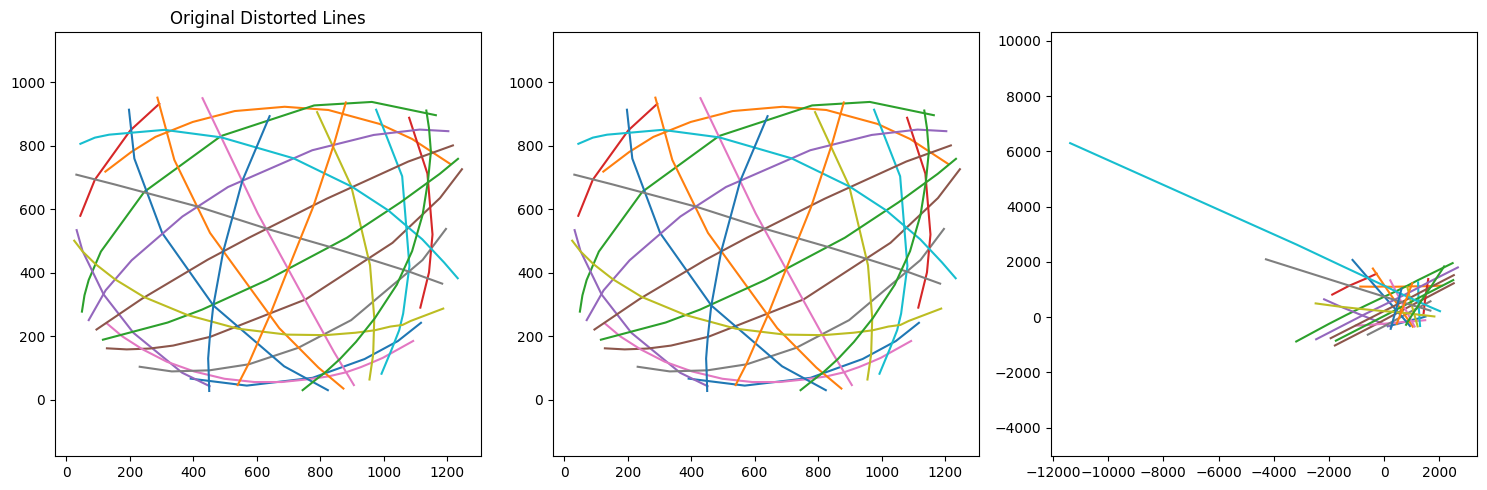

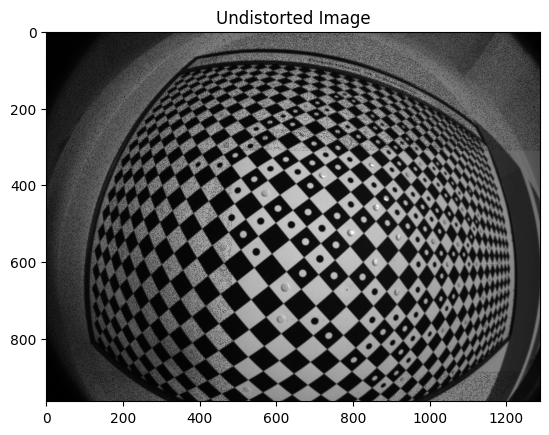

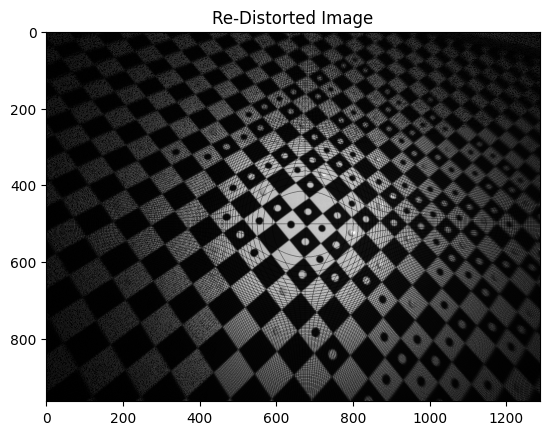

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

class RadialDistortionUndistorter:
    def __init__(self, image_center, focal_length):
        self.center_x, self.center_y = image_center
        self.f = focal_length

    def undistort_point(self, x_distorted, y_distorted):
        # Step 1: Compute the distorted radius r'
        x_rel_distorted = x_distorted - self.center_x
        y_rel_distorted = y_distorted - self.center_y
        r_distorted = np.sqrt(x_rel_distorted**2 + y_rel_distorted**2)

        if r_distorted == 0:  # Avoid divide-by-zero at the center
            return x_distorted, y_distorted

        # Step 2: Compute the undistorted radius r using the equi-angular model
        theta = np.arctan(r_distorted / self.f)  # Angle between optical axis and point
        r_undistorted = self.f * np.tan(theta)  # Radial correction using the equi-angular model

        # Step 3: Scale distorted coordinates to compute undistorted coordinates
        x_undistorted = self.center_x + (r_undistorted / r_distorted) * x_rel_distorted
        y_undistorted = self.center_y + (r_undistorted / r_distorted) * y_rel_distorted

        return x_undistorted, y_undistorted

    def distort_point(self, x_undistorted, y_undistorted):
        # Step 4: Transform undistorted coordinates back to distorted coordinates
        x_rel_undistorted = x_undistorted - self.center_x
        y_rel_undistorted = y_undistorted - self.center_y
        r_undistorted = np.sqrt(x_rel_undistorted**2 + y_rel_undistorted**2)

        if r_undistorted == 0:  # Avoid divide-by-zero at the center
            return x_undistorted, y_undistorted

        # Step 5: Calculate distorted radius using the equi-angular model
        theta = r_undistorted / self.f  # Angle theta
        r_distorted = self.f * np.tan(theta)  # Radial distortion model

        # Step 6: Scale undistorted coordinates to compute distorted coordinates
        x_distorted = self.center_x + (r_distorted / r_undistorted) * x_rel_undistorted
        y_distorted = self.center_y + (r_distorted / r_undistorted) * y_rel_undistorted

        return x_distorted, y_distorted

    def undistort_line(self, line):
        x_coords, y_coords = line
        undistorted_coords = np.array([self.undistort_point(x, y) for x, y in zip(x_coords, y_coords)])
        return undistorted_coords.T

    def distort_line(self, line):
        x_coords, y_coords = line
        distorted_coords = np.array([self.distort_point(x, y) for x, y in zip(x_coords, y_coords)])
        return distorted_coords.T

def main():
    # Load image data
    im1 = plt.imread('/content/drive/MyDrive/3DCV/4_01.png')
    im2 = plt.imread('/content/drive/MyDrive/3DCV/4_02.png')

    # Load line data
    lines_data = sio.loadmat('/content/drive/MyDrive/3DCV/4_lines.mat')
    lines = lines_data['lines'][0]

    # Define undistorter with given parameters
    im_center = [676, 503]
    f = 456
    undistorter = RadialDistortionUndistorter(im_center, f)

    # Undistort lines
    undistorted_lines = [undistorter.undistort_line(l) for l in lines]

    # Re-distort (inverse relationship) the undistorted lines
    re_distorted_lines = [undistorter.distort_line(l) for l in undistorted_lines]

    # Plot all lines
    plt.figure(figsize=(15, 5))

    # Original distorted lines
    plt.subplot(1, 3, 1)
    plt.title('Original Distorted Lines')
    for l in lines:
        plt.plot(l[0], l[1])
    plt.axis('equal')

    # Undistorted lines
    plt.subplot(1, 3, 2)
    # plt.title('Undistorted Lines')
    for ul in undistorted_lines:
        plt.plot(ul[0], ul[1])
    plt.axis('equal')

    # Re-distorted lines
    plt.subplot(1, 3, 3)
    # plt.title('Re-Distorted Lines')
    for rl in re_distorted_lines:
        plt.plot(rl[0], rl[1])
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Undistort the first image
    undistorted_im1 = np.zeros_like(im1)

    for i in range(im1.shape[0]):
        for j in range(im1.shape[1]):
            x_undistorted, y_undistorted = undistorter.undistort_point(j, i)
            if 0 <= int(x_undistorted) < im1.shape[1] and 0 <= int(y_undistorted) < im1.shape[0]:
                undistorted_im1[int(y_undistorted), int(x_undistorted)] = im1[i, j]

    # Save or visualize the undistorted image
    plt.imshow(undistorted_im1, cmap='gray')
    plt.title('Undistorted Image')
    plt.show()

    # Transform the undistorted image back to distorted coordinates
    re_distorted_im1 = np.zeros_like(im1)

    for i in range(undistorted_im1.shape[0]):
        for j in range(undistorted_im1.shape[1]):
            x_distorted, y_distorted = undistorter.distort_point(j, i)
            if 0 <= int(x_distorted) < im1.shape[1] and 0 <= int(y_distorted) < im1.shape[0]:
                re_distorted_im1[int(y_distorted), int(x_distorted)] = undistorted_im1[i, j]

    # Save or visualize the re-distorted image
    plt.imshow(re_distorted_im1, cmap='gray')
    plt.title('Re-Distorted Image')
    plt.show()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


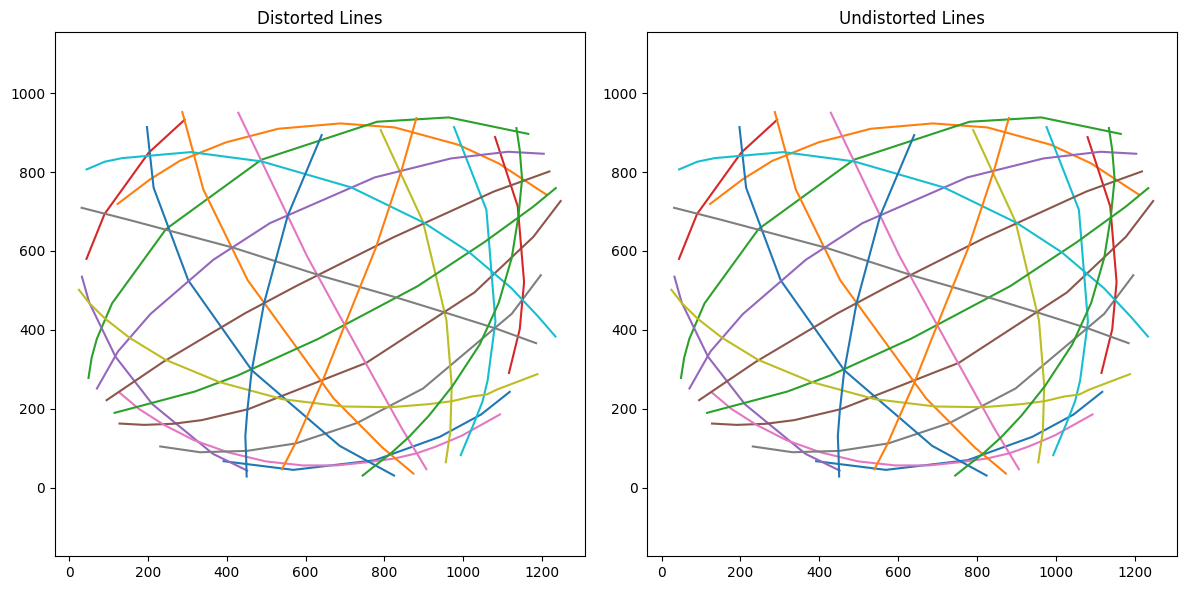

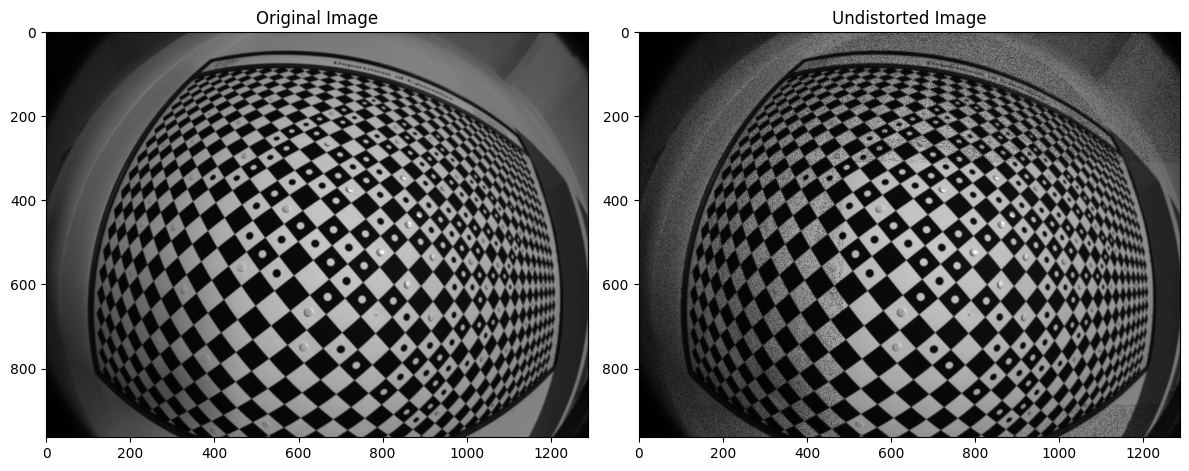

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import interp2d

class RadialDistortionUndistorter:
    def __init__(self, image_center, focal_length):
        self.center_x, self.center_y = image_center
        self.f = focal_length

    def undistort_point(self, x_distorted, y_distorted):
        # Step 1: Compute the distorted radius r'
        x_rel_distorted = x_distorted - self.center_x
        y_rel_distorted = y_distorted - self.center_y
        r_distorted = np.sqrt(x_rel_distorted**2 + y_rel_distorted**2)

        if r_distorted == 0:  # Avoid divide-by-zero at the center
            return x_distorted, y_distorted

        # Step 2: Compute the undistorted radius r using the equi-angular model
        theta = np.arctan(r_distorted / self.f)  # Angle between optical axis and point
        r_undistorted = self.f * np.tan(theta)  # Radial correction using the equi-angular model

        # Step 3: Scale distorted coordinates to compute undistorted coordinates
        x_undistorted = self.center_x + (r_undistorted / r_distorted) * x_rel_distorted
        y_undistorted = self.center_y + (r_undistorted / r_distorted) * y_rel_distorted

        return x_undistorted, y_undistorted

    def distort_point(self, x_undistorted, y_undistorted):
        # Step 4: Transform undistorted coordinates back to distorted coordinates
        x_rel_undistorted = x_undistorted - self.center_x
        y_rel_undistorted = y_undistorted - self.center_y
        r_undistorted = np.sqrt(x_rel_undistorted**2 + y_rel_undistorted**2)

        if r_undistorted == 0:  # Avoid divide-by-zero at the center
            return x_undistorted, y_undistorted

        # Step 5: Calculate distorted radius using the equi-angular model
        theta = r_undistorted / self.f  # Angle theta
        r_distorted = self.f * np.tan(theta)  # Radial distortion model

        # Step 6: Scale undistorted coordinates to compute distorted coordinates
        x_distorted = self.center_x + (r_distorted / r_undistorted) * x_rel_undistorted
        y_distorted = self.center_y + (r_distorted / r_undistorted) * y_rel_undistorted

        return x_distorted, y_distorted

    def undistort_line(self, line):
        x_coords, y_coords = line
        undistorted_coords = np.array([self.undistort_point(x, y) for x, y in zip(x_coords, y_coords)])
        return undistorted_coords.T

    def distort_line(self, line):
        x_coords, y_coords = line
        distorted_coords = np.array([self.distort_point(x, y) for x, y in zip(x_coords, y_coords)])
        return distorted_coords.T

def main():
    # Load image data
    im1 = plt.imread('/content/drive/MyDrive/3DCV/4_01.png')
    im2 = plt.imread('/content/drive/MyDrive/3DCV/4_02.png')

    # Load line data
    lines_data = sio.loadmat('/content/drive/MyDrive/3DCV/4_lines.mat')
    lines = lines_data['lines'][0]

    # Define undistorter with given parameters
    im_center = [676, 503]
    f = 456
    undistorter = RadialDistortionUndistorter(im_center, f)

    # Undistort lines
    undistorted_lines = [undistorter.undistort_line(l) for l in lines]

    # Plot distorted and undistorted lines
    plt.figure(figsize=(12, 6))

    # Distorted lines
    plt.subplot(1, 2, 1)
    plt.title('Distorted Lines')
    for l in lines:
        plt.plot(l[0], l[1], label='Distorted Line')
    plt.axis('equal')

    # Undistorted lines
    plt.subplot(1, 2, 2)
    plt.title('Undistorted Lines')
    for ul in undistorted_lines:
        plt.plot(ul[0], ul[1], label='Undistorted Line')
    plt.axis('equal')

    plt.tight_layout()
    plt.show()

    # Initialize undistorted images
    undistorted_im1 = np.zeros_like(im1)
    undistorted_im2 = np.zeros_like(im2)

    # For each pixel in the distorted image, compute the corresponding undistorted pixel
    for i in range(im1.shape[0]):
        for j in range(im1.shape[1]):
            x_undistorted, y_undistorted = undistorter.undistort_point(j, i)
            if 0 <= int(x_undistorted) < im1.shape[1] and 0 <= int(y_undistorted) < im1.shape[0]:
                undistorted_im1[int(y_undistorted), int(x_undistorted)] = im1[i, j]

    for i in range(im2.shape[0]):
        for j in range(im2.shape[1]):
            x_undistorted, y_undistorted = undistorter.undistort_point(j, i)
            if 0 <= int(x_undistorted) < im2.shape[1] and 0 <= int(y_undistorted) < im2.shape[0]:
                undistorted_im2[int(y_undistorted), int(x_undistorted)] = im2[i, j]

    # Plot original and undistorted images
    plt.figure(figsize=(12, 6))

    # Original images
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(im1, cmap='gray')

    # Undistorted images
    plt.subplot(1, 2, 2)
    plt.title('Undistorted Image')
    plt.imshow(undistorted_im1, cmap='gray')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()